# Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [3]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
import os
import h5py
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from functools import reduce

adding pardir


In [4]:
# Add the path to the parent directory to augment search for module
par_dir = os.pardir

if par_dir not in sys.path:
    print("adding pardir")
    sys.path.append(par_dir)
    sys.path.append("../..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

## Load Data

In [2]:
# Import test events from h5 file

original_data_path = "/data/WatChMaL/data/IWCD_mPMT_Short_e-mu-gamma_E0to1000MeV_digihits.h5"
data_file = h5py.File(original_data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(original_data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(original_data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(original_data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

#original_radius = [np.sqrt(original_positions[i,0,0]**2 + original_positions[i,0,2]**2) for i in range(original_positions.shape[0])]


<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


## Split Datasets

In [3]:
idxs_path = './new_dataset_data/equal_indices.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

In [4]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]

test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")


Done train info
Done val info
Done test info


In [5]:
# compute event radii
"""
train_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]
val_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]
test_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

np.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])
"""

"\ntrain_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]\nval_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]\ntest_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]\n\nnp.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])\n"

In [6]:
f = np.load('./new_dataset_data/event_radii.npz', allow_pickle=True)

train_info['radius'] = f['train_radii']
val_info['radius']   = f['val_radii']
test_info['radius']  = f['test_radii']

In [7]:
dataset_info = [train_info,val_info,test_info]

# Initialize Detector Geometry Parameters

In [8]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

# Distribution of event energies

In [9]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26

In [10]:
shifted_energies = []
for idx in range(3):
    shifted_energies.append(np.zeros(dataset_info[idx]['labels'].shape[0]))
    
    g_idxs = np.where(dataset_info[idx]['labels']==0)[0]
    e_idxs = np.where(dataset_info[idx]['labels']==1)[0]
    m_idxs = np.where(dataset_info[idx]['labels']==2)[0]
    
    shifted_energies[idx][g_idxs] = np.squeeze(dataset_info[idx]['energies'][g_idxs] - GAMMA_THRESHOLD)
    shifted_energies[idx][e_idxs] = np.squeeze(dataset_info[idx]['energies'][e_idxs] - ELECTRON_THRESHOLD)
    shifted_energies[idx][m_idxs] = np.squeeze(dataset_info[idx]['energies'][m_idxs] - MUON_THRESHOLD)

<Figure size 432x288 with 0 Axes>

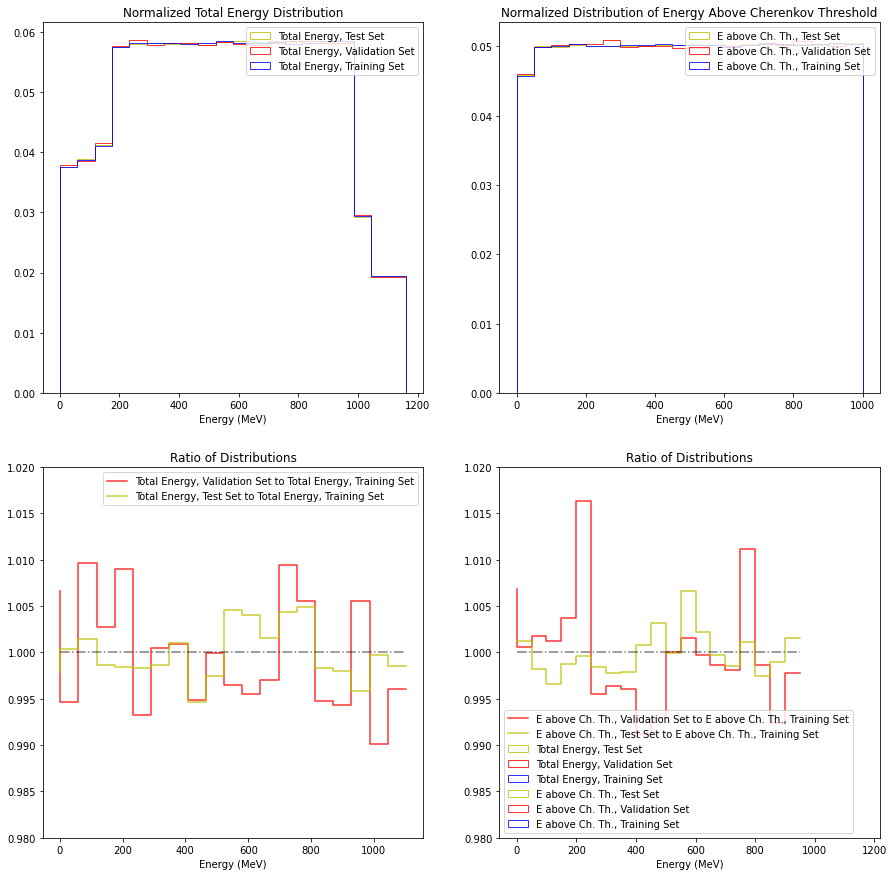

In [11]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
ax = axes[0]

plot_compare_dists([np.squeeze(data['energies']) for data in dataset_info], [1,2],[0,0],
                   ['Total Energy, {}'.format(data['name'])for data in dataset_info],
                   colors=('b','r','y'),ratio_range=[0.98,1.02],title='Normalized Total Energy Distribution',
                   xlabel='Energy (MeV)',axes=axes[[0,2]]
                  )

plot_compare_dists([shifted_energies[i] for i in range(3)], [1,2],[0,0],
                   ['E above Ch. Th., {}'.format(data['name'])for data in dataset_info],
                   colors=('b','r','y'),ratio_range=[0.98,1.02],title='Normalized Distribution of Energy Above Cherenkov Threshold',
                   xlabel='Energy (MeV)',axes=axes[[1,3]]
                  )

## Gamma Events

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

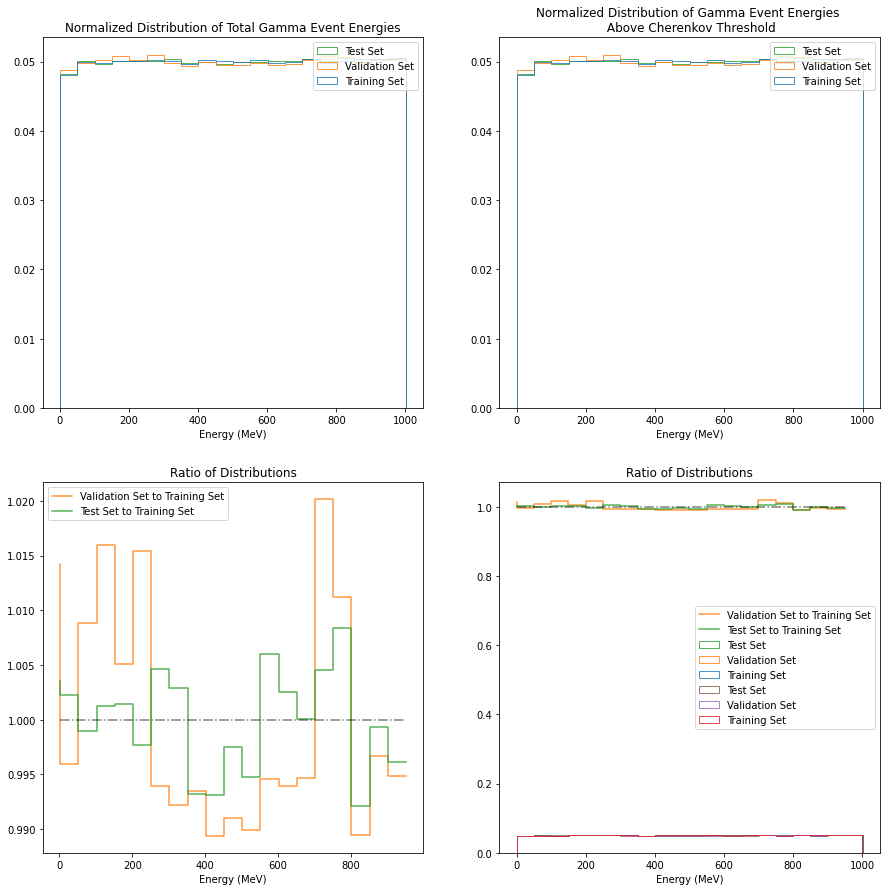

In [12]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()

train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]



plot_compare_dists(np.squeeze(np.array([dataset_info[0]['energies'][train_g_idxs],
                    dataset_info[1]['energies'][val_g_idxs],
                    dataset_info[2]['energies'][test_g_idxs]])),
                    [1,2],
                    [0,0],
                    [data['name'] for data in dataset_info],
                    title='Normalized Distribution of Total Gamma Event Energies',
                    axes = axes[[0,2]],
                    xlabel='Energy (MeV)'
                    )

plot_compare_dists(np.squeeze(np.array([shifted_energies[0][train_g_idxs],
                    shifted_energies[1][val_g_idxs],
                    shifted_energies[2][test_g_idxs]])),
                    [1,2],
                    [0,0],
                    [data['name'] for data in dataset_info],
                    title='Normalized Distribution of Gamma Event Energies \n Above Cherenkov Threshold',
                    axes = axes[[1,3]],
                    xlabel='Energy (MeV)'
                    )

## Electron Events

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

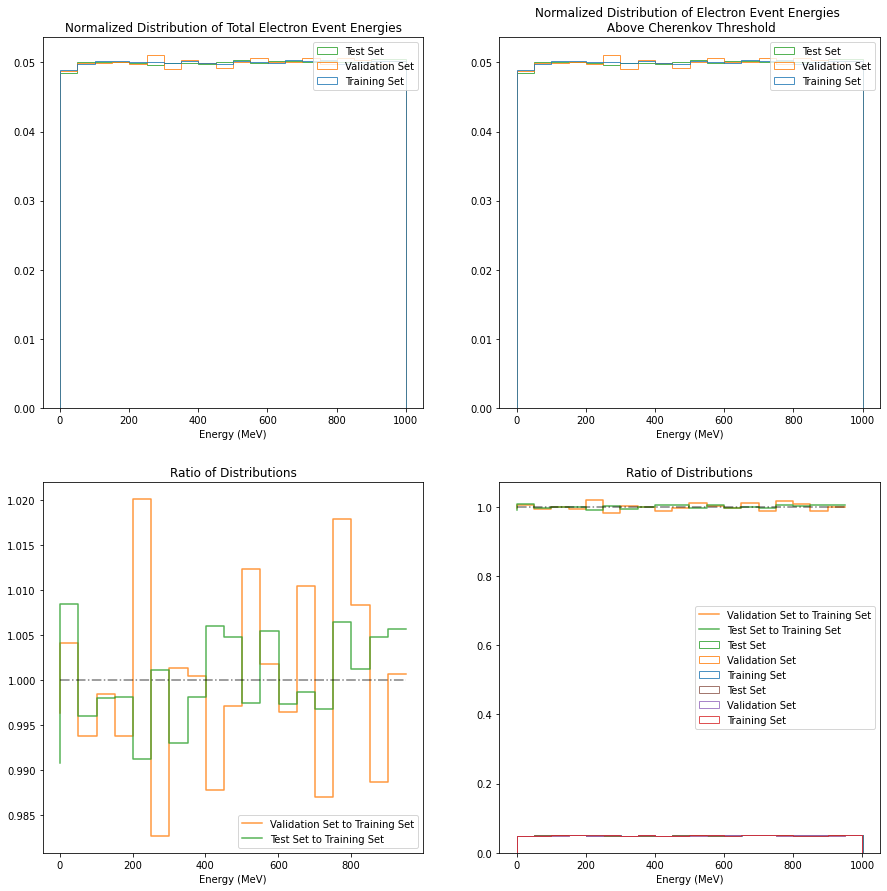

In [13]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()

train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs = np.where(dataset_info[2]['labels']==1)[0]

plot_compare_dists(np.squeeze(np.array([dataset_info[0]['energies'][train_e_idxs],
                    dataset_info[1]['energies'][val_e_idxs],
                    dataset_info[2]['energies'][test_e_idxs]])),
                    [1,2],
                    [0,0],
                    [data['name'] for data in dataset_info],
                    title='Normalized Distribution of Total Electron Event Energies',
                    axes = axes[[0,2]],
                    xlabel='Energy (MeV)'
                    )

plot_compare_dists(np.squeeze(np.array([shifted_energies[0][train_e_idxs],
                    shifted_energies[1][val_e_idxs],
                    shifted_energies[2][test_e_idxs]])),
                    [1,2],
                    [0,0],
                    [data['name'] for data in dataset_info],
                    title='Normalized Distribution of Electron Event Energies \n Above Cherenkov Threshold', 
                    axes = axes[[1,3]],
                    xlabel='Energy (MeV)'
                    )

## Muon Events

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

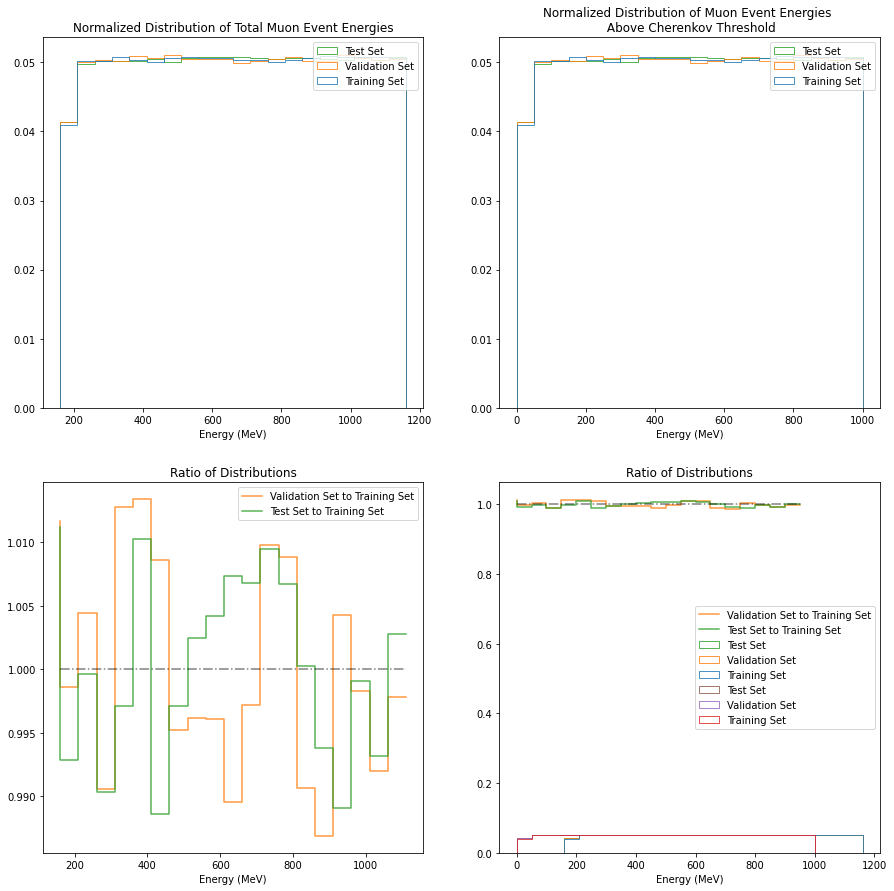

In [14]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs = np.where(dataset_info[2]['labels']==2)[0]

plot_compare_dists(np.squeeze(np.array([dataset_info[0]['energies'][train_m_idxs],
                    dataset_info[1]['energies'][val_m_idxs],
                    dataset_info[2]['energies'][test_m_idxs]])),
                    [1,2],
                    [0,0],
                    [data['name'] for data in dataset_info],
                    title='Normalized Distribution of Total Muon Event Energies',
                    axes = axes[[0,2]],
                    xlabel='Energy (MeV)'
                    )

plot_compare_dists(np.squeeze(np.array([shifted_energies[0][train_m_idxs],
                    shifted_energies[1][val_m_idxs],
                    shifted_energies[2][test_m_idxs]])),
                    [1,2],
                    [0,0],
                    [data['name'] for data in dataset_info],
                    title='Normalized Distribution of Muon Event Energies \n Above Cherenkov Threshold', 
                    axes = axes[[1,3]], xlabel='Energy (MeV)'
                    )

# Distribution of event departure angles

<Figure size 432x288 with 0 Axes>

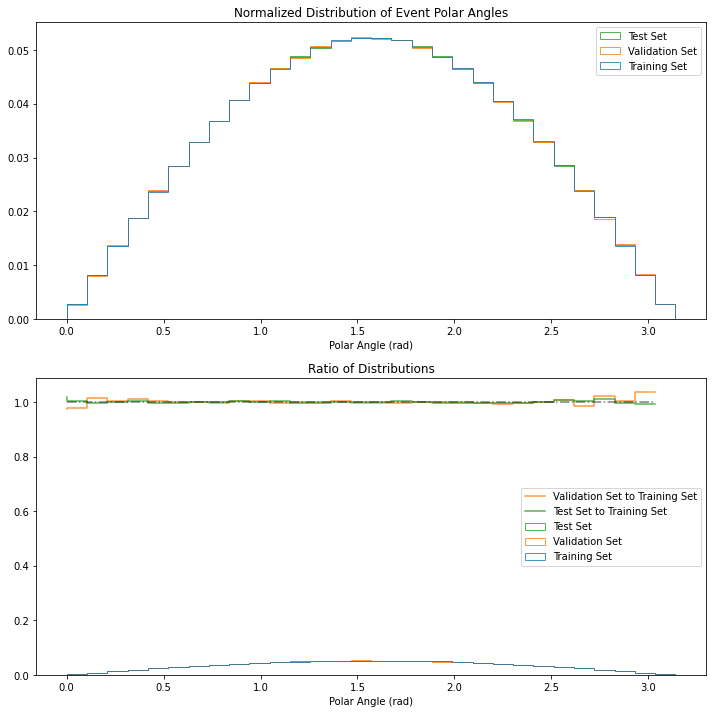

In [15]:
plt.figure()
fig,axes = plt.subplots(2,1,figsize=(12,12))
axes = axes.flatten()

plot_compare_dists(([data['angles'][:,0] for data in dataset_info]),[1,2],[0,0],[data['name'] for data in dataset_info],
                    bins=30,title='Normalized Distribution of Event Polar Angles',axes=axes, xlabel='Polar Angle (rad)')

<Figure size 432x288 with 0 Axes>

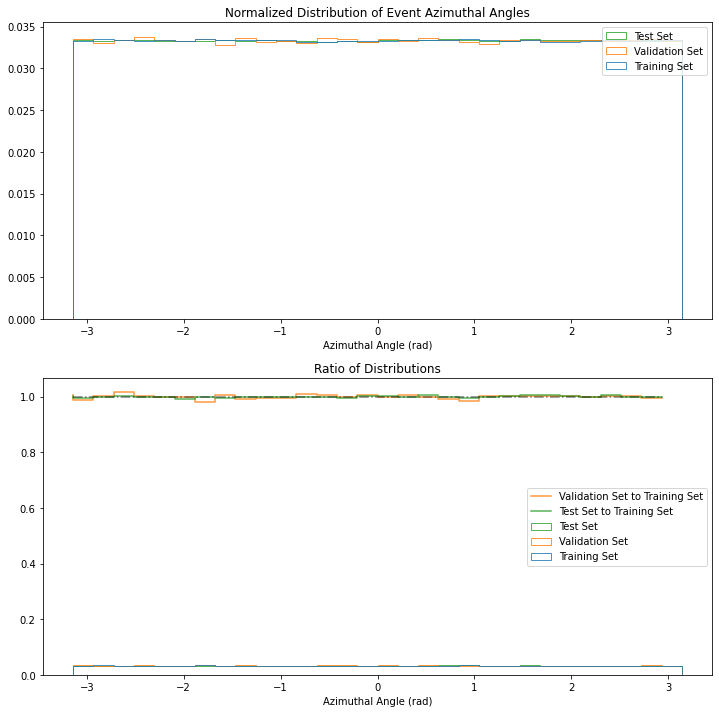

In [16]:
plt.figure()
fig,axes = plt.subplots(2,1,figsize=(12,12))
axes = axes.flatten()

plot_compare_dists(([data['angles'][:,1] for data in dataset_info]),[1,2],[0,0],[data['name'] for data in dataset_info],
                    bins=30,title='Normalized Distribution of Event Azimuthal Angles',axes=axes, xlabel='Azimuthal Angle (rad)')


<Figure size 432x288 with 0 Axes>

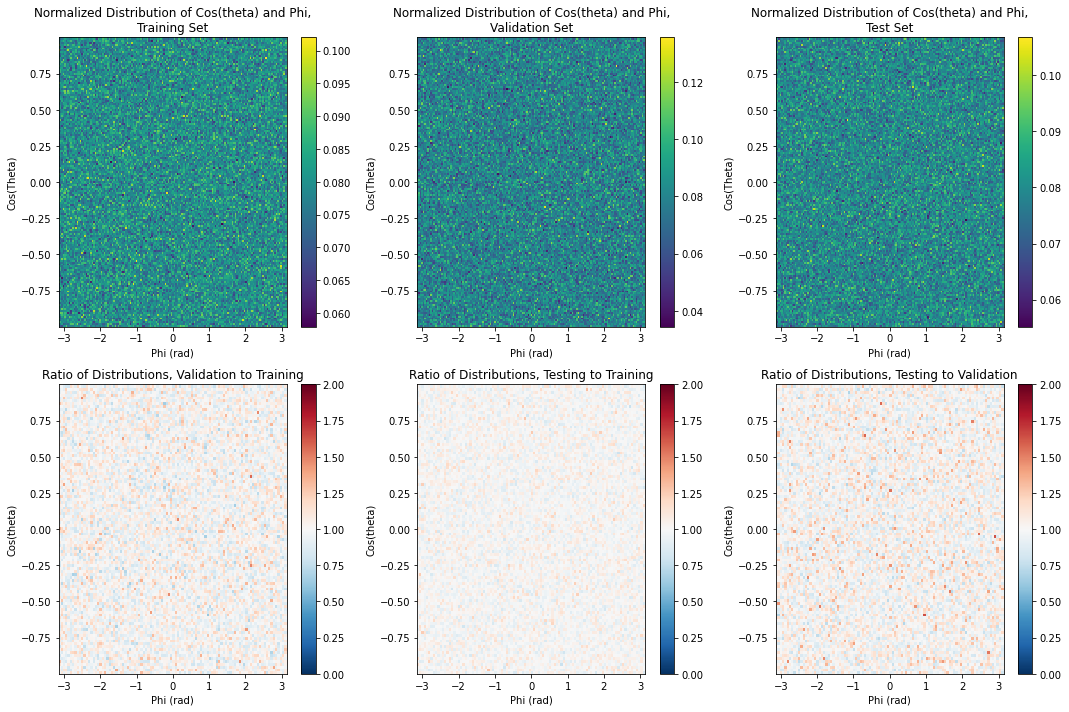

In [17]:
plt.figure()
fig,axes = plt.subplots(2,3,figsize=(15,10))
axes = axes.flatten()

for idx in range(3):
    ax = axes[idx]
    mat,_,_,im = ax.hist2d(dataset_info[idx]['angles'][:,1], np.cos(dataset_info[idx]['angles'][:,0]),[150,150],density=True)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution of Cos(theta) and Phi,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Cos(Theta)')
    ax.set_xlabel('Phi (rad)')

fig = plot_2d_ratio(dataset_info[1]['angles'][:,1], np.cos(dataset_info[1]['angles'][:,0]),
                      dataset_info[0]['angles'][:,1], np.cos(dataset_info[0]['angles'][:,0]),bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',ylabel='Cos(theta)',xlabel='Phi (rad)',
                      fig=fig, ax=axes[3],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['angles'][:,1], np.cos(dataset_info[2]['angles'][:,0]),
                      dataset_info[0]['angles'][:,1], np.cos(dataset_info[0]['angles'][:,0]),bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',ylabel='Cos(theta)',xlabel='Phi (rad)',
                      fig=fig, ax=axes[4],ratio_range=[0,2])
fig = plot_2d_ratio(dataset_info[2]['angles'][:,1], np.cos(dataset_info[2]['angles'][:,0]),
                      dataset_info[1]['angles'][:,1], np.cos(dataset_info[1]['angles'][:,0]),bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',ylabel='Cos(theta)',xlabel='Phi (rad)',
                      fig=fig, ax=axes[5],ratio_range=[0,2])

plt.tight_layout()
plt.show()

# Distribution of events throughout the detector volume

<Figure size 432x288 with 0 Axes>

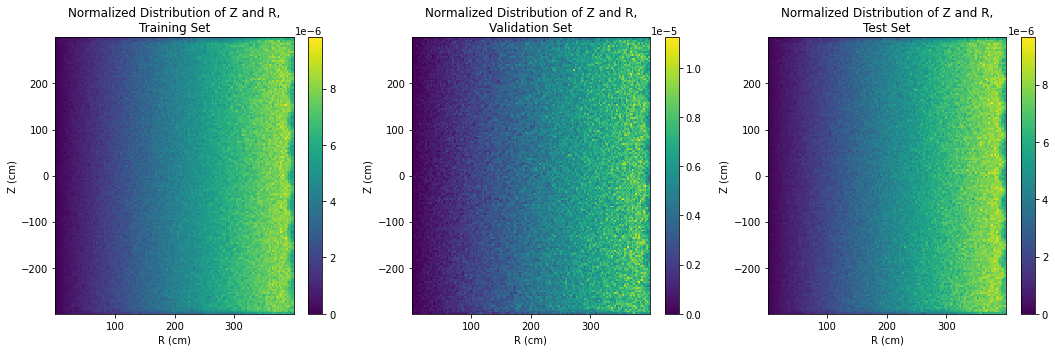

In [18]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))

for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['radius'], dataset_info[idx]['positions'][:,0,1],[150,150],density=True)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution of Z and R,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Z (cm)')
    ax.set_xlabel('R (cm)')
    
plt.tight_layout()
plt.show()


../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:944: RuntimeWarning: divide by zero encountered in true_divide
  ratio = ns_1/ns_2


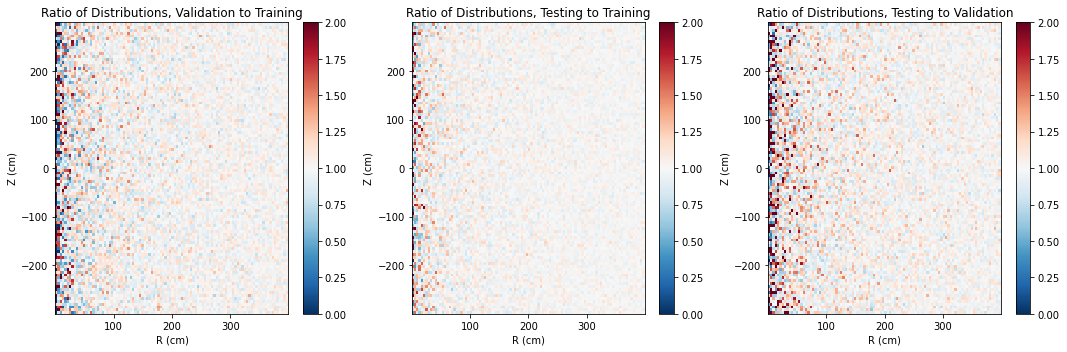

In [19]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

fig = plot_2d_ratio(dataset_info[1]['radius'], dataset_info[1]['positions'][:,0,1],
                      dataset_info[0]['radius'], dataset_info[0]['positions'][:,0,1],bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',xlabel='R (cm)',ylabel='Z (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])

fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['positions'][:,0,1],
                      dataset_info[0]['radius'], dataset_info[0]['positions'][:,0,1],bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',xlabel='R (cm)',ylabel='Z (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])

fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['positions'][:,0,1],
                      dataset_info[1]['radius'], dataset_info[1]['positions'][:,0,1],bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',xlabel='R (cm)',ylabel='Z (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

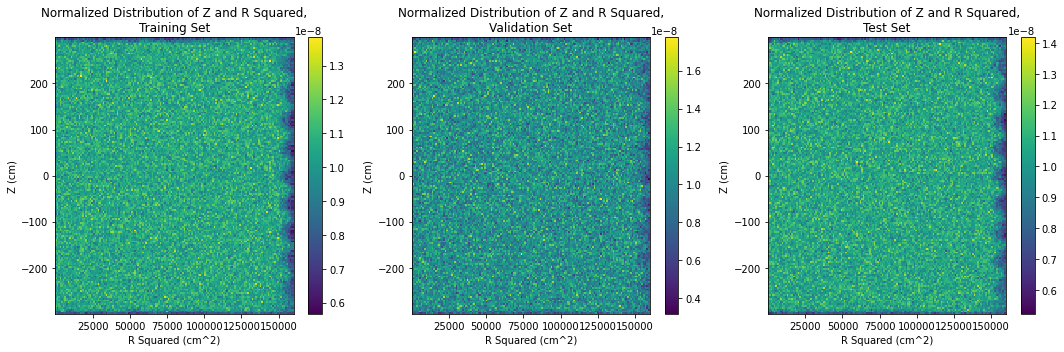

In [20]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))

bins=(150,150)
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(list(map(lambda x : x**2,dataset_info[idx]['radius'])), 
                           dataset_info[idx]['positions'][:,0,1],bins,density=True)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution of Z and R Squared,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Z (cm)')
    ax.set_xlabel('R Squared (cm^2)')
    
plt.tight_layout()
plt.show()

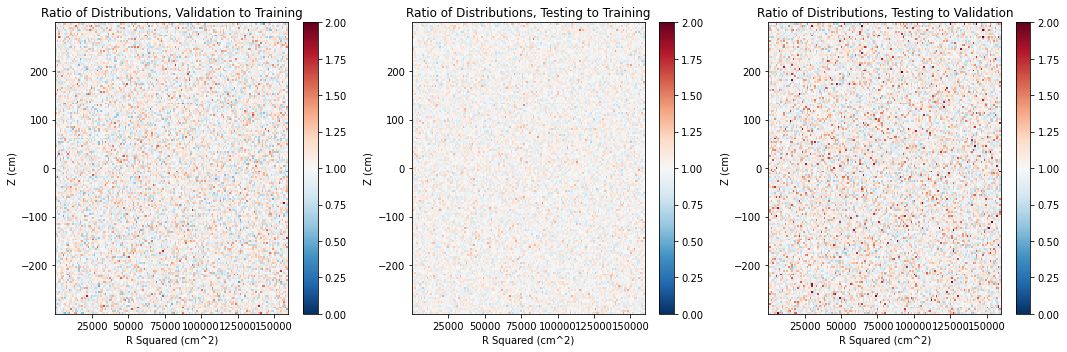

In [21]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

bins=(150,150)
fig = plot_2d_ratio(list(map(lambda x : x**2,dataset_info[1]['radius'])), dataset_info[1]['positions'][:,0,1],
                      list(map(lambda x : x**2,dataset_info[0]['radius'])), dataset_info[0]['positions'][:,0,1],
                      bins=bins,
                      title='Ratio of Distributions, Validation to Training',xlabel='R Squared (cm^2)',ylabel='Z (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])

fig = plot_2d_ratio(list(map(lambda x : x**2,dataset_info[2]['radius'])), dataset_info[2]['positions'][:,0,1],
                      list(map(lambda x : x**2,dataset_info[0]['radius'])), dataset_info[0]['positions'][:,0,1],
                      bins=bins,
                      title='Ratio of Distributions, Testing to Training',xlabel='R Squared (cm^2)',ylabel='Z (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])

fig = plot_2d_ratio(list(map(lambda x : x**2,dataset_info[2]['radius'])), dataset_info[2]['positions'][:,0,1],
                      list(map(lambda x : x**2,dataset_info[1]['radius'])), dataset_info[1]['positions'][:,0,1],bins=bins,
                      title='Ratio of Distributions, Testing to Validation',xlabel='R Squared (cm^2)',ylabel='Z (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])

plt.tight_layout()

# Distribution of total charge

In [22]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
            ' ', ETA()], maxval=len(train_idxs))

pbar.start()
for i in range(len(train_idxs)):
    pbar.update(i)
    
    item = train_idxs[i]
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]
    charge = hit_charge[start:stop]
    
    total_charge.append(np.sum(charge))
pbar.finish()

dataset_info[0]['total_charge'] = np.array(total_charge)

np.savez('./new_dataset_data/training_set_total_charge.npz', total_charge=dataset_info[0]['total_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Total Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n            ' ', ETA()], maxval=len(train_idxs))\n\npbar.start()\nfor i in range(len(train_idxs)):\n    pbar.update(i)\n    \n    item = train_idxs[i]\n    start = event_hits_index[item]\n    stop  = event_hits_index[item + 1]\n    charge = hit_charge[start:stop]\n    \n    total_charge.append(np.sum(charge))\npbar.finish()\n\ndataset_info[0]['total_charge'] = np.array(total_charge)\n\nnp.savez('./new_dataset_data/training_set_total_charge.npz', total_charge=dataset_info[0]['total_charge'])\n"

In [23]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(val_idxs))

pbar.start()
for i in range(len(val_idxs)):
    pbar.update(i)
    
    item = val_idxs[i]
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]
    charge = hit_charge[start:stop]
    
    total_charge.append(np.sum(charge))
pbar.finish()

dataset_info[1]['total_charge'] = np.array(total_charge)

np.savez('./new_dataset_data/validation_set_total_charge.npz', total_charge=dataset_info[1]['total_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=len(val_idxs))\n\npbar.start()\nfor i in range(len(val_idxs)):\n    pbar.update(i)\n    \n    item = val_idxs[i]\n    start = event_hits_index[item]\n    stop  = event_hits_index[item + 1]\n    charge = hit_charge[start:stop]\n    \n    total_charge.append(np.sum(charge))\npbar.finish()\n\ndataset_info[1]['total_charge'] = np.array(total_charge)\n\nnp.savez('./new_dataset_data/validation_set_total_charge.npz', total_charge=dataset_info[1]['total_charge'])\n"

In [24]:
dataset_info[0]['total_charge'] = np.load('./new_dataset_data/training_set_total_charge.npz',allow_pickle=True)['total_charge']
dataset_info[1]['total_charge'] = np.load('./new_dataset_data/validation_set_total_charge.npz',allow_pickle=True)['total_charge']

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

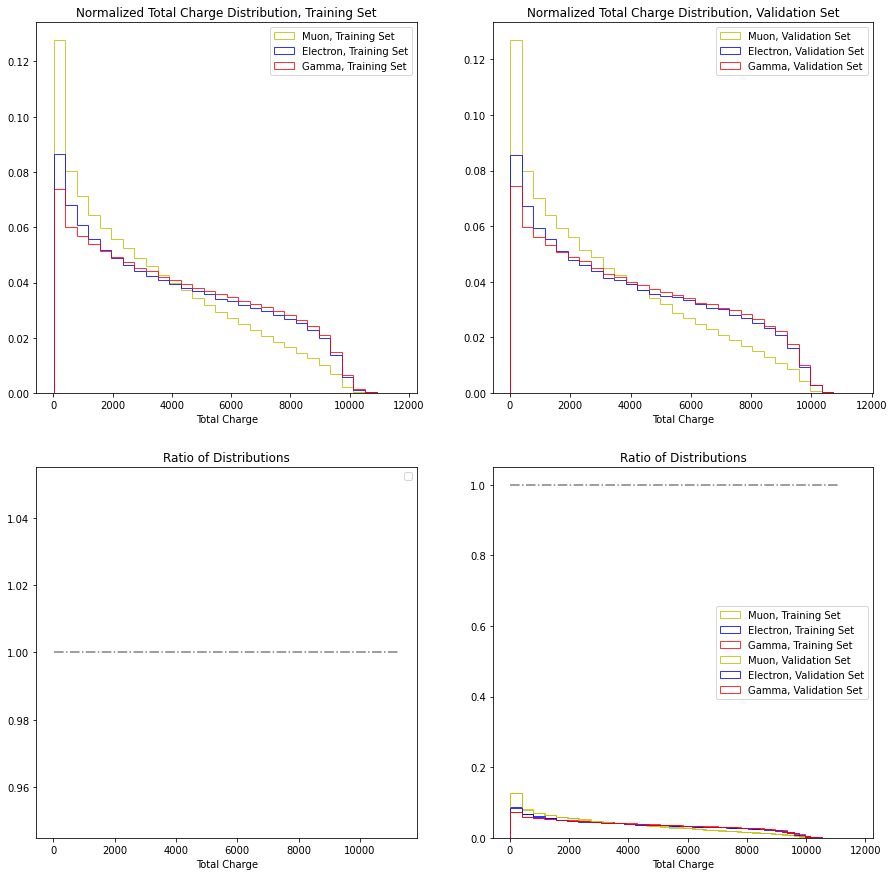

In [58]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()

N_BINS = 40
for i in range(2):
    g_idxs = np.where(dataset_info[i]['labels']==0)[0]
    e_idxs = np.where(dataset_info[i]['labels']==1)[0]
    m_idxs = np.where(dataset_info[i]['labels']==2)[0]
    
    plot_compare_dists(( dataset_info[i]['total_charge'][g_idxs],
                         dataset_info[i]['total_charge'][e_idxs],
                         dataset_info[i]['total_charge'][m_idxs]),
                         bins=30,
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [], 
                         labels = [
                         'Gamma, {}'.format(dataset_info[i]['name']),
                         'Electron, {}'.format(dataset_info[i]['name']),
                         'Muon, {}'.format(dataset_info[i]['name'])],
                         colors = ('r','b','y'), 
                         axes = axes[[i,i+2]],
                         title='Normalized Total Charge Distribution, {}'.format(dataset_info[i]['name']),
                         xlabel='Total Charge'
                           )

../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


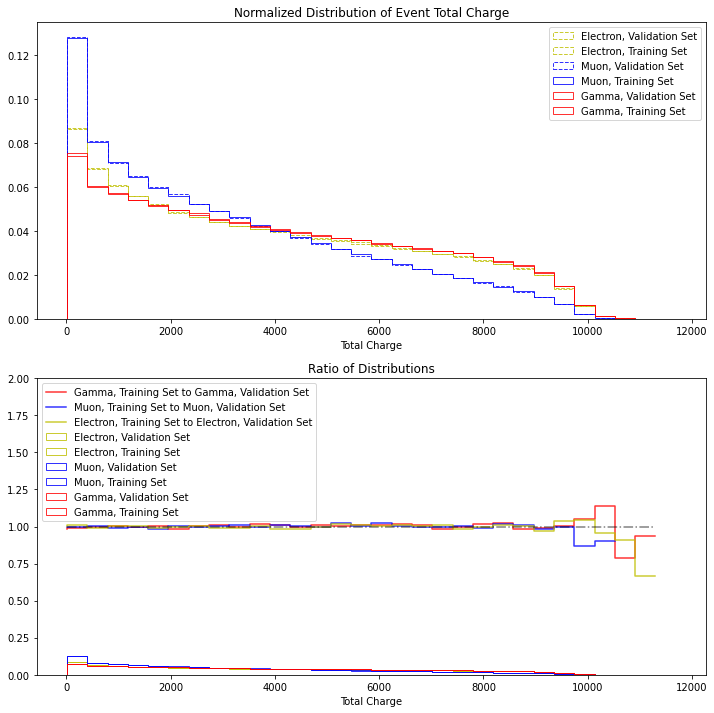

In [60]:
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]

val_g_idxs = np.where(dataset_info[1]['labels']==0)[0]
val_e_idxs = np.where(dataset_info[1]['labels']==1)[0]
val_m_idxs = np.where(dataset_info[1]['labels']==2)[0]

fig = plot_compare_dists([
                    dataset_info[0]['total_charge'][train_g_idxs], dataset_info[1]['total_charge'][val_g_idxs],
                    dataset_info[0]['total_charge'][train_m_idxs], dataset_info[1]['total_charge'][val_m_idxs],
                    dataset_info[1]['total_charge'][val_e_idxs], dataset_info[0]['total_charge'][train_e_idxs]],
                    bins=30,
                    numerator_dist_idxs   = [0,2,4],
                    denominator_dist_idxs = [1,3,5],
                    labels= ['Gamma, Training Set', 'Gamma, Validation Set',
                             'Muon, Training Set', 'Muon, Validation Set',
                             'Electron, Training Set', 'Electron, Validation Set'],
                    ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',
                    colors=['r','r','b','b','y','y'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Total Charge'
                    )

# Distribution of distance to wall along particle trajectory

In [28]:
"""
pbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))

pbar.start()
done=0
for dset in dataset_info:
    d_to_wall = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        d_to_wall.append(distance_to_wall(dset['positions'][i][0], dset['angles'][i]))
        dset['d_to_wall'] = d_to_wall
    done = done + dset['positions'].shape[0]
pbar.finish()

np.savez('./new_dataset_data/dist_to_wall.npz',train_d_to_wall= dataset_info[0]['d_to_wall'],
                            val_d_to_wall  = dataset_info[1]['d_to_wall'],
                            test_d_to_wall = dataset_info[2]['d_to_wall'])
"""

"\npbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))\n\npbar.start()\ndone=0\nfor dset in dataset_info:\n    d_to_wall = []\n    for i in range(dset['positions'].shape[0]):\n        pbar.update(done + i)\n        d_to_wall.append(distance_to_wall(dset['positions'][i][0], dset['angles'][i]))\n        dset['d_to_wall'] = d_to_wall\n    done = done + dset['positions'].shape[0]\npbar.finish()\n\nnp.savez('./new_dataset_data/dist_to_wall.npz',train_d_to_wall= dataset_info[0]['d_to_wall'],\n                            val_d_to_wall  = dataset_info[1]['d_to_wall'],\n                            test_d_to_wall = dataset_info[2]['d_to_wall'])\n"

In [29]:
f = np.load('./new_dataset_data/dist_to_wall.npz', allow_pickle=True)

dataset_info[0]['d_to_wall'] = f['train_d_to_wall']
dataset_info[1]['d_to_wall'] = f['val_d_to_wall']
dataset_info[2]['d_to_wall'] = f['test_d_to_wall']

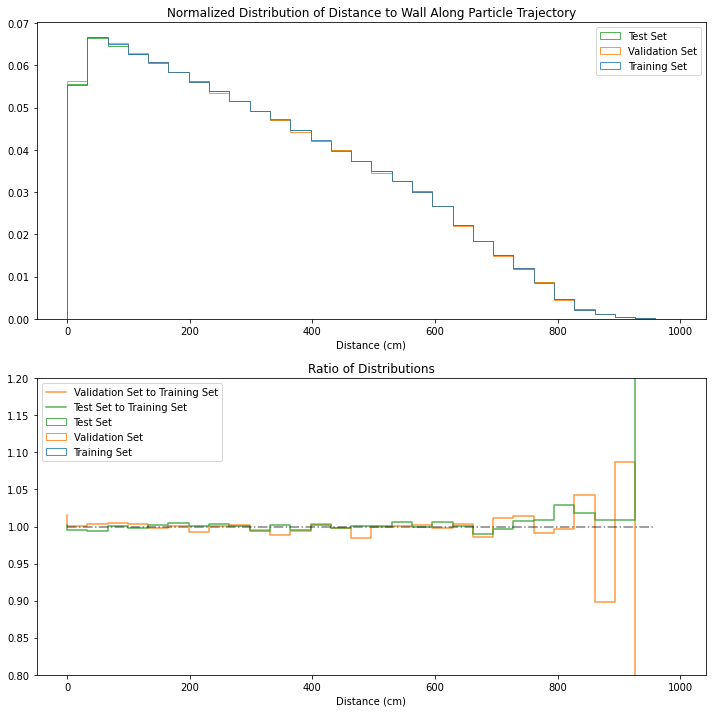

In [46]:
patches = plot_compare_dists(([data['d_to_wall'] for data in dataset_info]), 
                             numerator_dist_idxs   = [1,2],
                             denominator_dist_idxs = [0,0], 
                             bins=30,
                             labels=[data['name'] for data in dataset_info],
                             title='Normalized Distribution of Distance to Wall Along Particle Trajectory',
                             ratio_range=[0.8,1.2],
                             xlabel='Distance (cm)')


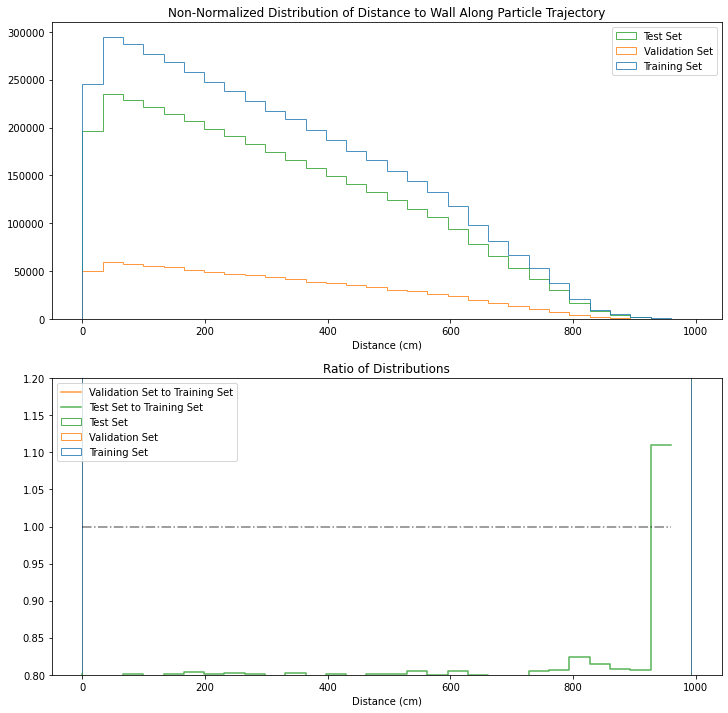

In [47]:
patches = plot_compare_dists(([data['d_to_wall'] for data in dataset_info]), 
                             numerator_dist_idxs   = [1,2],
                             denominator_dist_idxs = [0,0], 
                             bins=30,
                             labels=[data['name'] for data in dataset_info],
                             title='Non-Normalized Distribution of Distance to Wall Along Particle Trajectory',
                             ratio_range=[0.8,1.2],
                             xlabel='Distance (cm)', 
                             normalized=False)

<Figure size 432x288 with 0 Axes>

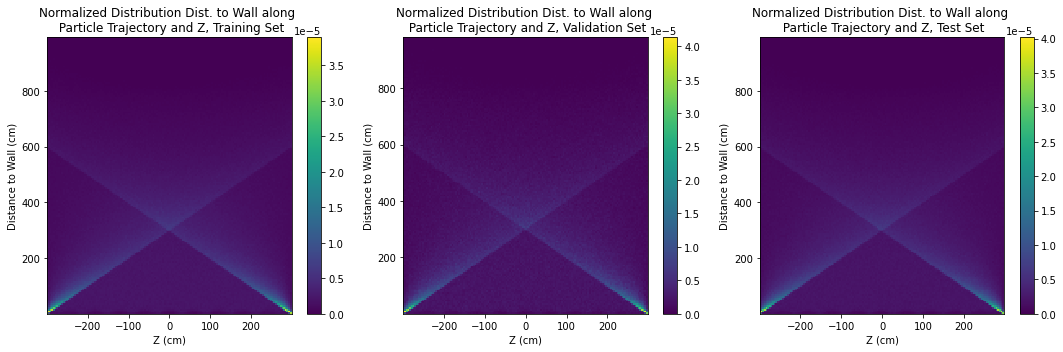

In [32]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))

for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['positions'][:,0,1], dataset_info[idx]['d_to_wall'],[150,150],density=True)
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Normalized Distribution Dist. to Wall along \n Particle Trajectory and Z, {}'.format(dataset_info[idx]['name']))
    ax.set_xlabel('Z (cm)')
    ax.set_ylabel('Distance to Wall (cm)')

plt.tight_layout()
plt.show()

../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:944: RuntimeWarning: divide by zero encountered in true_divide
  ratio = ns_1/ns_2
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:944: RuntimeWarning: invalid value encountered in true_divide
  ratio = ns_1/ns_2


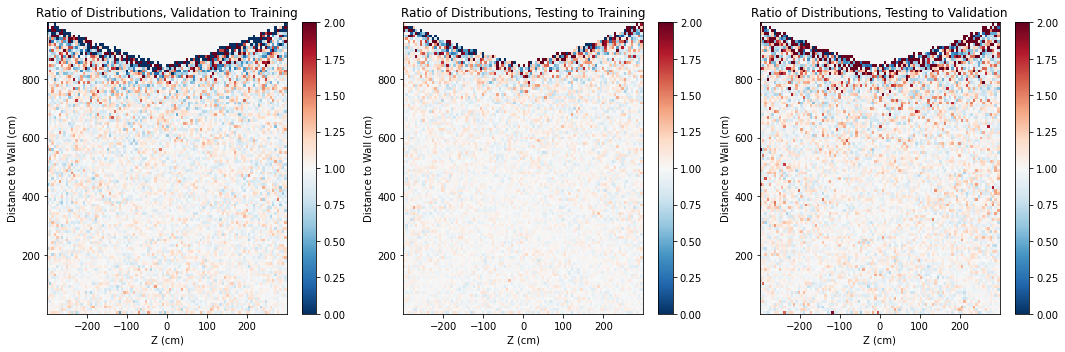

In [33]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

fig = plot_2d_ratio(dataset_info[1]['positions'][:,0,1], dataset_info[1]['d_to_wall'],
                      dataset_info[0]['positions'][:,0,1], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',xlabel='Z (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])

fig = plot_2d_ratio(dataset_info[2]['positions'][:,0,1], dataset_info[2]['d_to_wall'],
                      dataset_info[0]['positions'][:,0,1], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',xlabel='Z (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])

fig = plot_2d_ratio(dataset_info[2]['positions'][:,0,1], dataset_info[2]['d_to_wall'],
                      dataset_info[1]['positions'][:,0,1], dataset_info[1]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',xlabel='Z (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

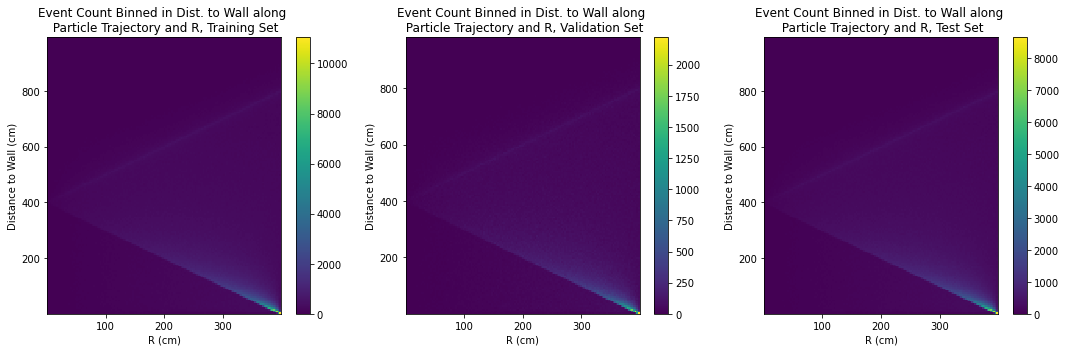

In [34]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(15,5))

for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['radius'], dataset_info[idx]['d_to_wall'],[150,150])
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Event Count Binned in Dist. to Wall along \n Particle Trajectory and R, {}'.format(dataset_info[idx]['name']))
    ax.set_xlabel('R (cm)')
    ax.set_ylabel('Distance to Wall (cm)')

plt.tight_layout()
plt.show()



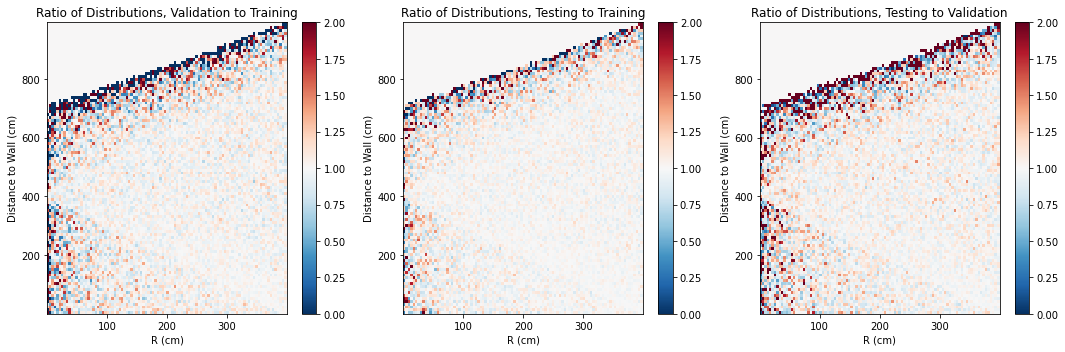

In [35]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

fig = plot_2d_ratio(dataset_info[1]['radius'], dataset_info[1]['d_to_wall'],
                      dataset_info[0]['radius'], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Validation to Training',xlabel='R (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[0],ratio_range=[0,2])

fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['d_to_wall'],
                      dataset_info[0]['radius'], dataset_info[0]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Training',xlabel='R (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[1],ratio_range=[0,2])

fig = plot_2d_ratio(dataset_info[2]['radius'], dataset_info[2]['d_to_wall'],
                      dataset_info[1]['radius'], dataset_info[1]['d_to_wall'],bins=(100,100),
                      title='Ratio of Distributions, Testing to Validation',xlabel='R (cm)',ylabel='Distance to Wall (cm)',
                      fig=fig, ax=axes[2],ratio_range=[0,2])

plt.tight_layout()

# Display some randomly selected test event data from edge events

In [36]:
from WatChMaL.analysis.plot_utils import get_plot_array

def get_event_data_from_index(item):
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]

    hit_pmts    = hit_pmt[start:stop].astype(np.int16)
    hit_charges = hit_charge[start:stop]
    hit_times   = hit_time[start:stop]

    hit_mpmts = hit_pmts // pmts_per_mpmt
    hit_pmt_in_modules = hit_pmts % pmts_per_mpmt

    hit_rows = mpmt_positions[hit_mpmts, 0]
    hit_cols = mpmt_positions[hit_mpmts, 1]

    sample_data = np.zeros(data_size)
    sample_data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

    # fix barrel array indexing to match endcaps in xyz ordering
    sample_data[:, 12:28, :] = sample_data[barrel_map_array_idxs, 12:28, :]
    moved_data = np.moveaxis(sample_data, 0, -1)
    return moved_data

In [37]:
test_event_data = get_event_data_from_index(0)

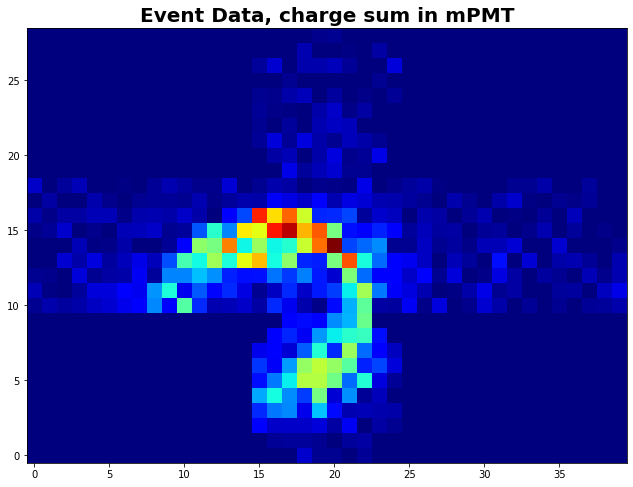

In [38]:
summed_event_data = np.sum(test_event_data, axis=-1)

fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
plt.imshow(summed_event_data, cmap='jet', origin='lower')
ax.set_title('Event Data, charge sum in mPMT',fontsize=20,fontweight='bold')
plt.show()

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  """


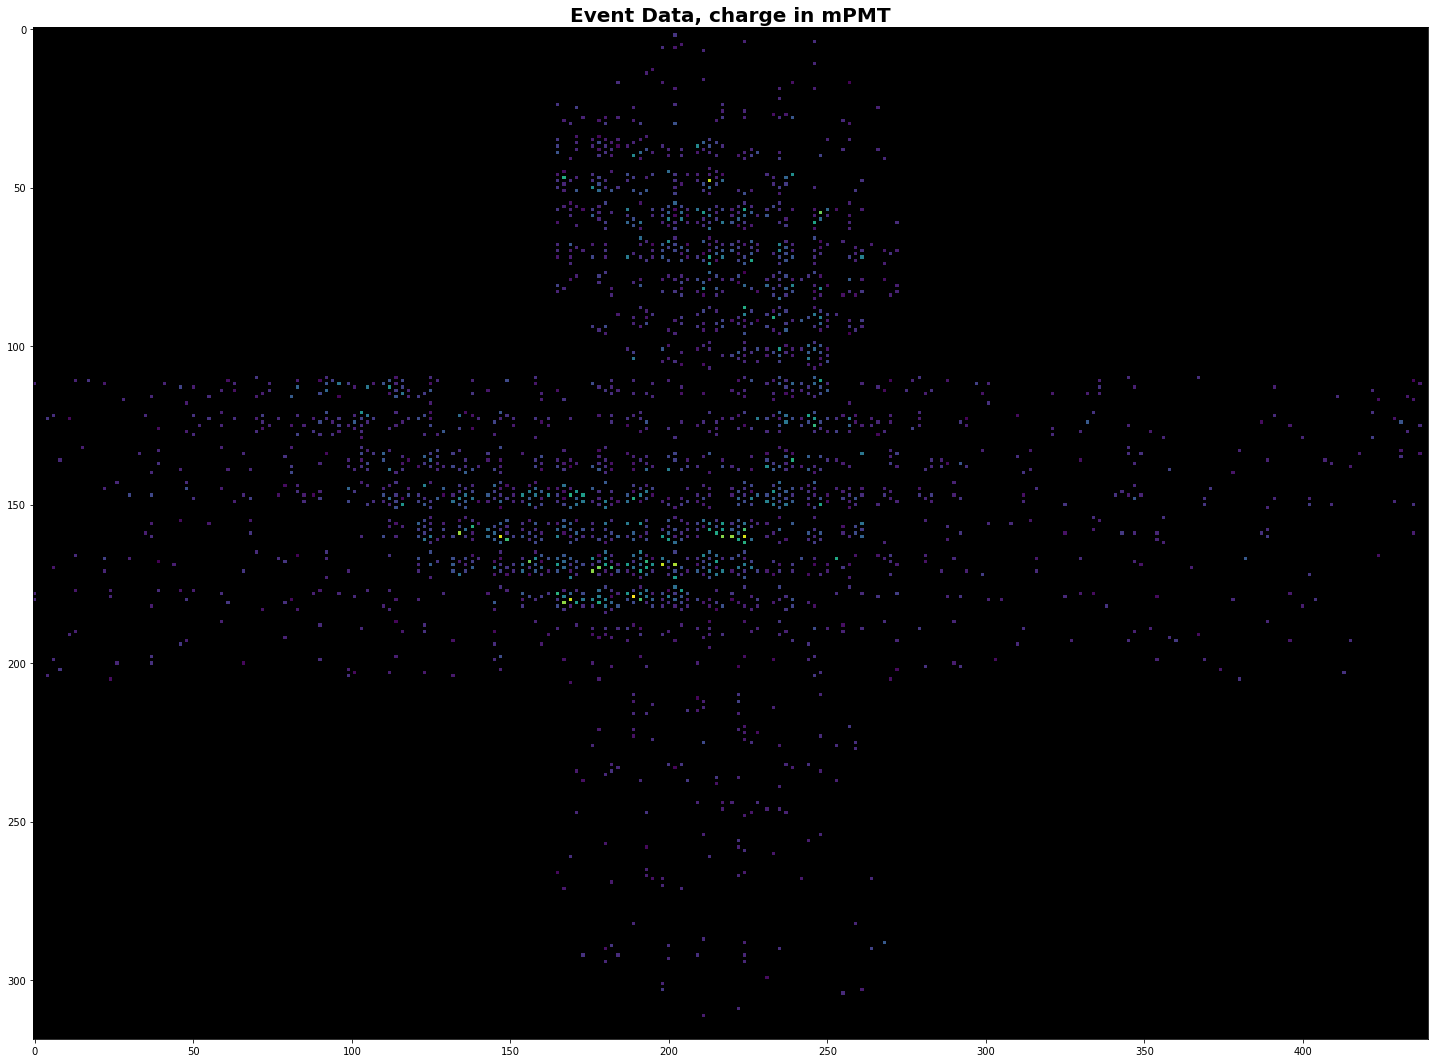

In [39]:
fig, axes = plt.subplots(1,1,figsize=(25,25),facecolor='w')
ax = axes

cmap = plt.cm.viridis
cmap.set_bad(color='black')

a = get_plot_array(test_event_data)
a = np.ma.masked_where(a < 0.05, a)

ax.imshow(a, 
          origin="upper",
          cmap=cmap)

ax.set_title('Event Data, charge in mPMT',fontsize=20,fontweight='bold')
plt.show()

In [61]:
"""
border_event_idxs = []
i = 0
search_idxs = np.random.permutation(len(test_radius))
while len(border_event_idxs) < 3:
    if test_radius[search_idxs[i]] > 360:
        border_event_idxs.append(search_idxs[i])
    i+=1
"""

'\nborder_event_idxs = []\ni = 0\nsearch_idxs = np.random.permutation(len(test_radius))\nwhile len(border_event_idxs) < 3:\n    if test_radius[search_idxs[i]] > 360:\n        border_event_idxs.append(search_idxs[i])\n    i+=1\n'

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  """


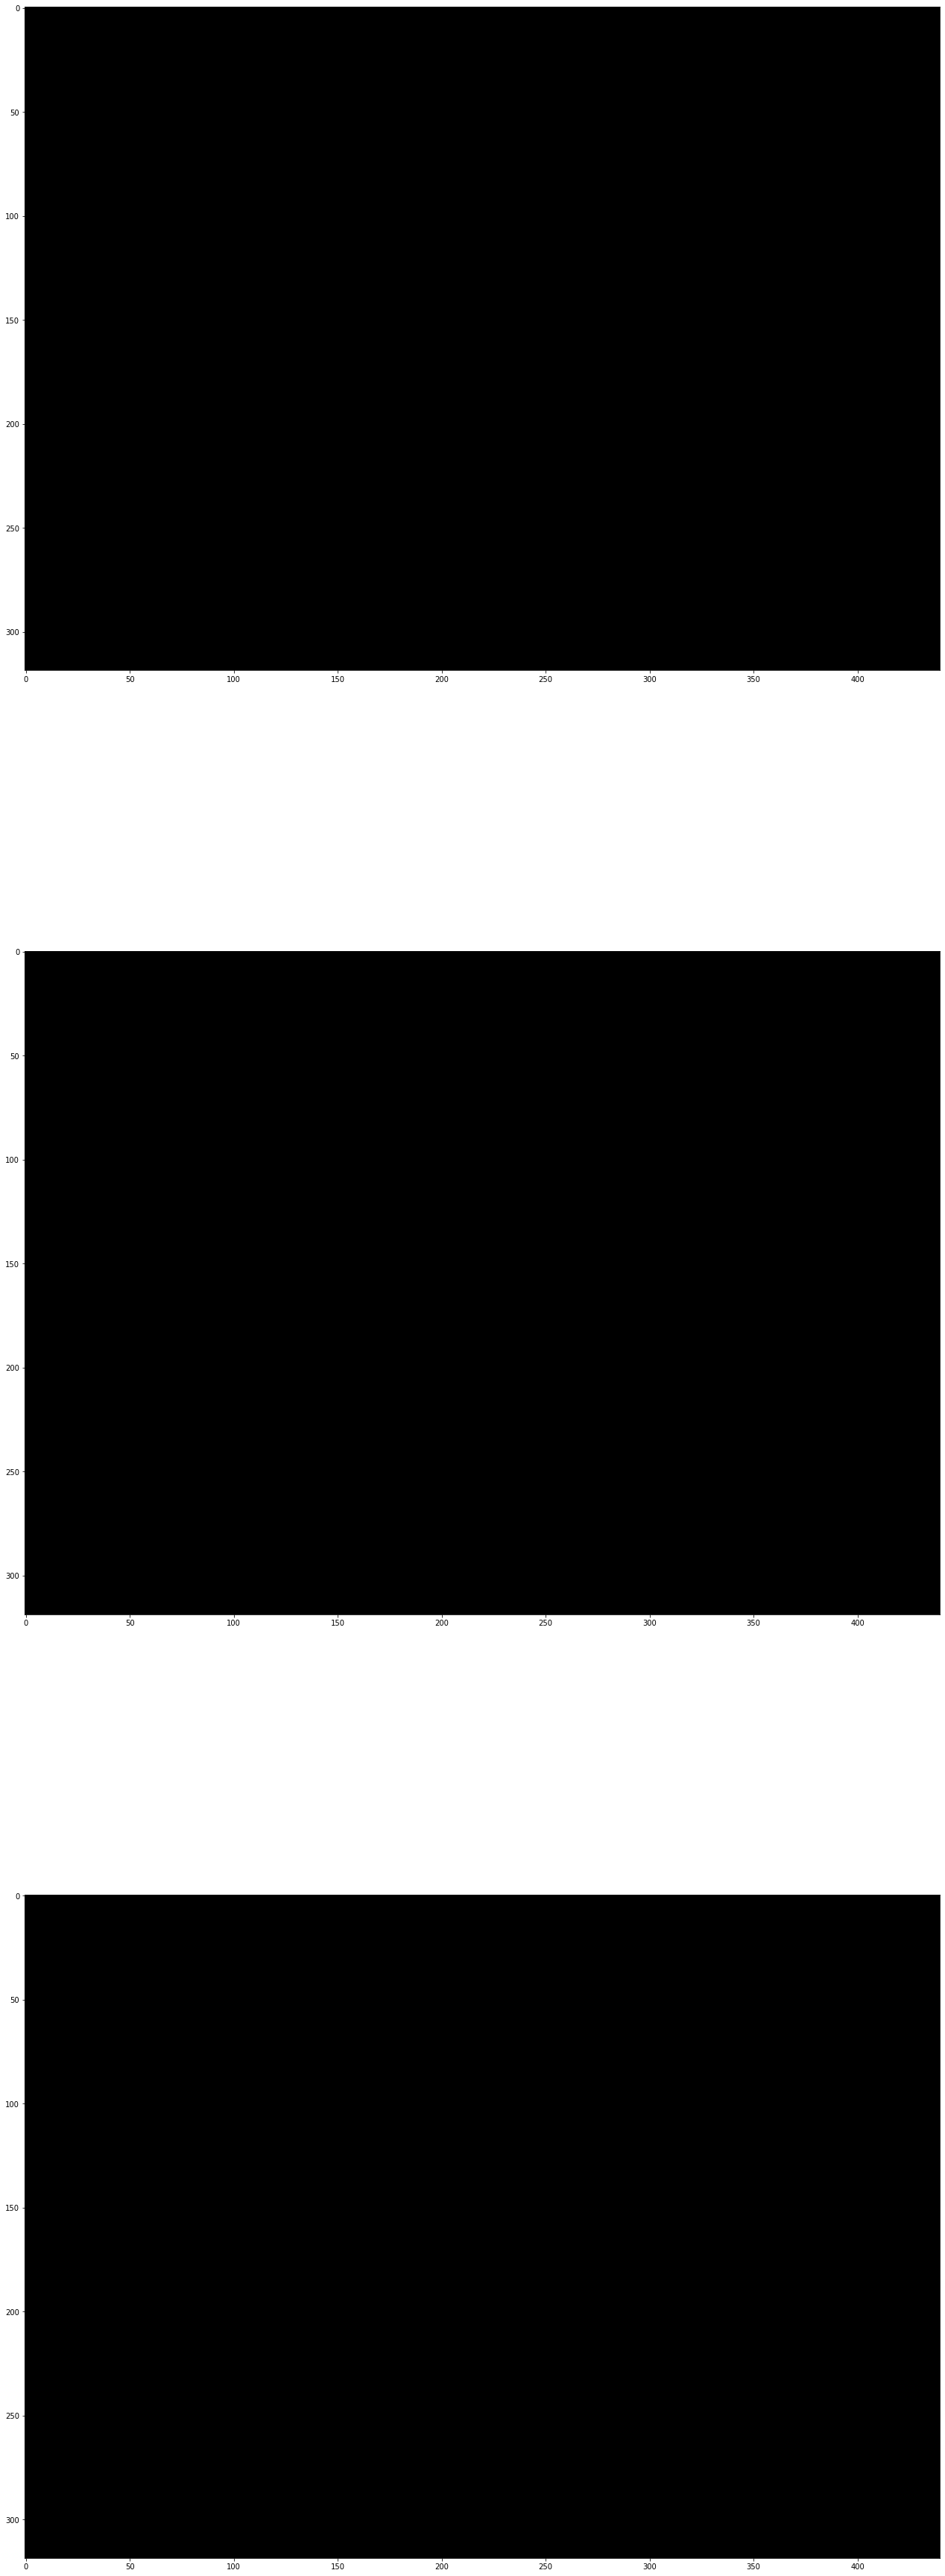

In [62]:
fig, axes = plt.subplots(3,1,figsize=(22,22*3), facecolor='w')
axes = axes.flatten()

cmap = plt.cm.viridis
cmap.set_bad(color='black')

for idx in range(len(axes)):
    ax = axes[idx]
    
    event_index = idx #border_event_idxs[np.random.randint(0, high=len(border_event_idxs))]
    a = get_plot_array(get_event_data_from_index(event_index))
    a = np.ma.masked_where(a < 0.05, a)
    
    ax.imshow(a,
               origin="upper",
               cmap=cmap)
plt.show()

# Example Event Breakdown

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

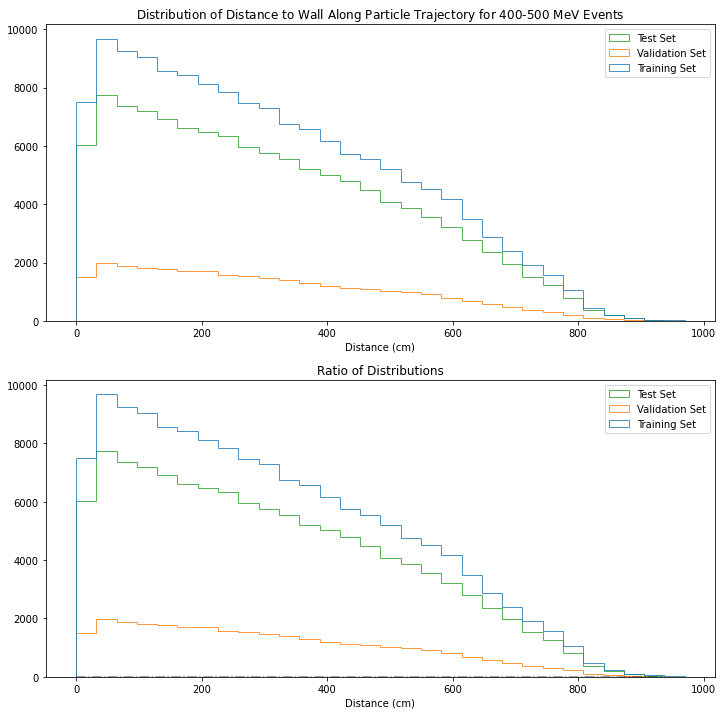

In [76]:
energy_bins = []

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

train_m_energies = dataset_info[0]['energies'][train_m_idxs]
val_m_energies   = dataset_info[1]['energies'][val_m_idxs]  
test_m_energies  = dataset_info[2]['energies'][test_m_idxs]


def get_idxs_satisfying_bounds(energies, lower_bound, upper_bound):
    return np.where((lower_bound < energies) & (energies <= upper_bound))[0]

valid_train_m_energy_idxs = get_idxs_satisfying_bounds(train_m_energies, 400, 500)
valid_val_m_energy_idxs   = get_idxs_satisfying_bounds(val_m_energies, 400, 500)
valid_test_m_energy_idxs  = get_idxs_satisfying_bounds(test_m_energies, 400, 500)

# print((dataset_info[0]['energies'])[train_m_idxs[valid_train_m_energy_idxs]])

train_bin_dist_to_wall = (dataset_info[0]['d_to_wall'])[train_m_idxs[valid_train_m_energy_idxs]]
val_bin_dist_to_wall   = (dataset_info[1]['d_to_wall'])[val_m_idxs[valid_val_m_energy_idxs]]
test_bin_dist_to_wall  = (dataset_info[2]['d_to_wall'])[test_m_idxs[valid_test_m_energy_idxs]]

plt.figure()
fig,axes = plt.subplots(2,1,figsize=(12,12))
axes = axes.flatten()

plot_compare_dists(np.squeeze(np.array([train_bin_dist_to_wall, 
                                        val_bin_dist_to_wall, 
                                        test_bin_dist_to_wall])),
                    bins=30,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[data['name'] for data in dataset_info],
                    title='Distribution of Distance to Wall Along Particle Trajectory for $400$-$500$ MeV Events',
                    axes = axes,
                    xlabel='Distance (cm)',
                    normalized=False
                    )

Minimum bin is  (921.5405496420224, 970.0417495693765)  with value  19
To achieve 10^4 events, we need a test set of size


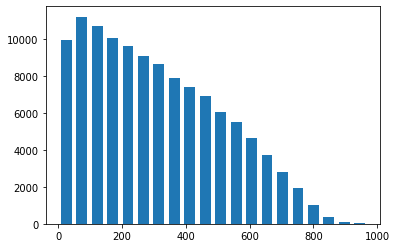

In [64]:
# bin data
hist, bins = np.histogram(test_bin_dist_to_wall, bins=20)

# find min
min_bin_idx = np.argmin(hist)
min_bin_val = hist[min_bin_idx]
min_bin_edges = (bins[min_bin_idx], bins[min_bin_idx + 1])

print("Minimum bin is ", min_bin_edges, " with value ", min_bin_val)
print("To achieve 10^4 events, we need a test set of size", )

# plot to verify working
center = (bins[:-1] + bins[1:]) / 2
width = 0.7 * (bins[1] - bins[0])
plt.bar(center, hist, align='center', width=width)
plt.show()

Minimum bin is  (950011.1481954296, 999964.498270512)  with value  4345


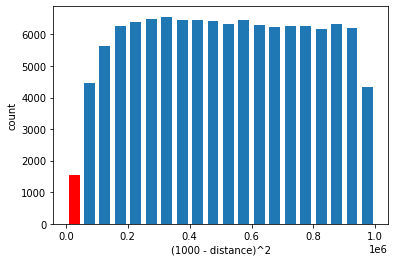

[4460 5632 6271 6379 6492 6559 6468 6465 6423 6340 6448 6311 6236 6256
 6252 6171 6325 6206 4345]


In [65]:
# bin data
N = 2
test_bin_dist_to_wall_squared = (1000 - test_bin_dist_to_wall)**N
base_hist, base_bins = np.histogram(test_bin_dist_to_wall_squared, bins= 20)

# find min
hist = base_hist[1:]
bins = base_bins[1:]
min_bin_idx = np.argmin(hist)
min_bin_val = hist[min_bin_idx]
min_bin_edges = (bins[min_bin_idx], bins[min_bin_idx + 1])

print("Minimum bin is ", min_bin_edges, " with value ", min_bin_val)


# plot to verify working
center = (base_bins[:-1] + base_bins[1:]) / 2
width = 0.7 * (base_bins[1] - base_bins[0])
barlist = plt.bar(center, base_hist, align='center', width=width)
barlist[0].set_color('r')
plt.ylabel('count')
plt.xlabel('(1000 - distance)^{}'.format(N))
plt.show()

print(hist)

In [66]:
print(test_bin_dist_to_wall_squared.shape)

(117599,)


# Event Breakdown By Energy for Muons

In [67]:
test_m_idxs       = np.where(dataset_info[2]['labels']==2)[0]
test_m_energies   = dataset_info[2]['energies'][test_m_idxs]
test_dist_to_wall = dataset_info[2]['d_to_wall']

# bin energy data
energy_hist, energy_bins = np.histogram(test_m_energies, bins=10)
print("Energy bins: ", energy_bins)


Energy bins:  [ 160.26176  260.2614   360.26108  460.2607   560.2604   660.26
  760.2597   860.25934  960.259   1060.2587  1160.2583 ]


In [68]:
size_of_data_subset = len(test_m_idxs)

def get_idxs_satisfying_bounds(energies, lower_bound, upper_bound):
    return np.where((lower_bound < energies) & (energies <= upper_bound))[0]

def analyze_bin_data(energies, indices, lower_bound, upper_bound, plot=True):
    valid_test_m_energy_idxs  = get_idxs_satisfying_bounds(energies, lower_bound, upper_bound)
    test_bin_dist_to_wall     = test_dist_to_wall[indices[valid_test_m_energy_idxs]]
    test_bin_dist_to_wall_squared = (1000 - test_bin_dist_to_wall)**N
    
    # bin data
    uncut_hist, uncut_bins = np.histogram(test_bin_dist_to_wall_squared, bins=base_bins)
    hist = uncut_hist[1:]
    bins = uncut_bins[1:]

    # find min
    min_bin_idx = np.argmin(hist)
    min_bin_val = hist[min_bin_idx]
    min_bin_edges = (bins[min_bin_idx], bins[min_bin_idx + 1])

    print("Minimum bin is ", min_bin_edges, " with value ", min_bin_val)
    test_set_size = 10**4 * size_of_data_subset / min_bin_val
    print("To achieve 10^4 events, we need a test set with ", test_set_size, " muon events")
    print("Test set must be ",  test_set_size / size_of_data_subset, " as large")

    # plot to verify working
    if plot:
        barlist = plt.bar(center, uncut_hist, align='center', width=width)
        barlist[0].set_color('r')
        plt.ylabel('count')
        plt.xlabel('(1000 - distance)^{}'.format(N))
        plt.show()
    
    return test_set_size


Bin:  (160.26176, 260.2614)
Minimum bin is  (950011.1481954296, 999964.498270512)  with value  2427
To achieve 10^4 events, we need a test set with  4822768.8504326325  muon events
Test set must be  4.120313143798929  as large


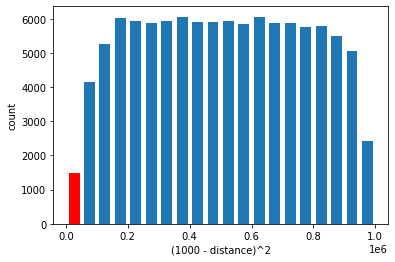

Bin:  (260.2614, 360.26108)
Minimum bin is  (950011.1481954296, 999964.498270512)  with value  4049
To achieve 10^4 events, we need a test set with  2890802.6673252657  muon events
Test set must be  2.469745616201531  as large


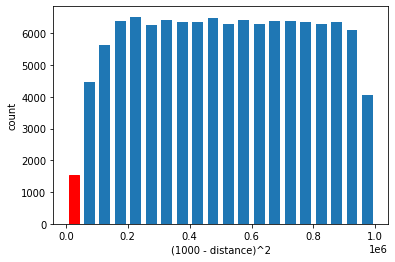

Bin:  (360.26108, 460.2607)
Minimum bin is  (950011.1481954296, 999964.498270512)  with value  4318
To achieve 10^4 events, we need a test set with  2710713.2931912923  muon events
Test set must be  2.3158869847151458  as large


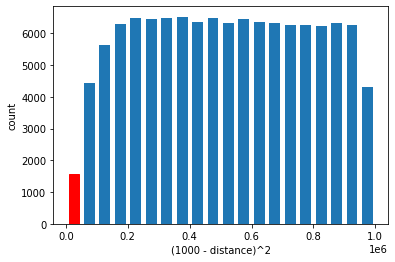

Bin:  (460.2607, 560.2604)
Minimum bin is  (950011.1481954296, 999964.498270512)  with value  4300
To achieve 10^4 events, we need a test set with  2722060.465116279  muon events
Test set must be  2.3255813953488373  as large


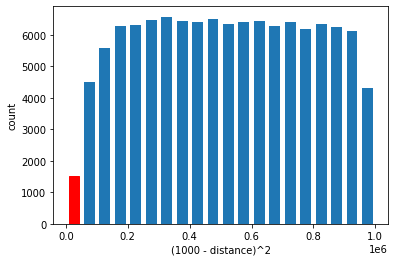

Bin:  (560.2604, 660.26)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4380
To achieve 10^4 events, we need a test set with  2672342.4657534244  muon events
Test set must be  2.28310502283105  as large


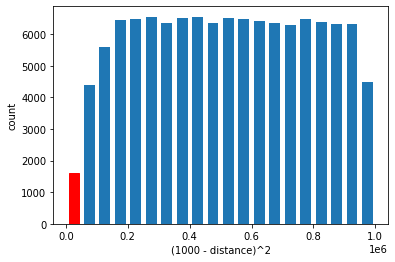

Bin:  (660.26, 760.2597)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4419
To achieve 10^4 events, we need a test set with  2648757.6374745416  muon events
Test set must be  2.2629554197782302  as large


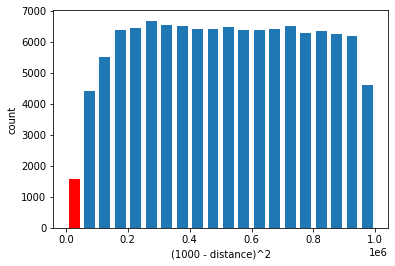

Bin:  (760.2597, 860.25934)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4298
To achieve 10^4 events, we need a test set with  2723327.1288971617  muon events
Test set must be  2.326663564448581  as large


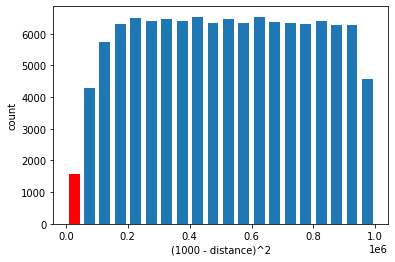

Bin:  (860.25934, 960.259)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4457
To achieve 10^4 events, we need a test set with  2626174.556876823  muon events
Test set must be  2.2436616558223017  as large


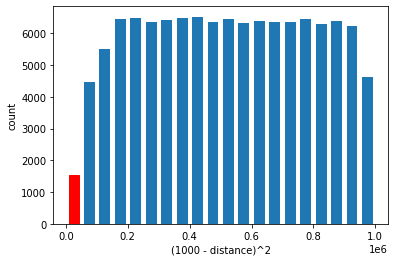

Bin:  (960.259, 1060.2587)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4380
To achieve 10^4 events, we need a test set with  2672342.4657534244  muon events
Test set must be  2.28310502283105  as large


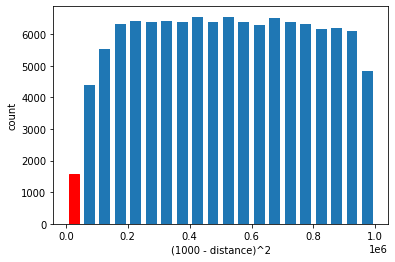

Bin:  (1060.2587, 1160.2583)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4369
To achieve 10^4 events, we need a test set with  2679070.725566491  muon events
Test set must be  2.288853284504463  as large


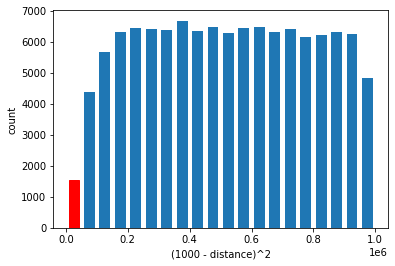

In [69]:
max_val = size_of_data_subset
for i in range(len(energy_bins) - 1):
    print("Bin: ", (energy_bins[i], energy_bins[i + 1]))
    test_set_size = analyze_bin_data(test_m_energies, test_m_idxs, energy_bins[i], energy_bins[i + 1], plot=True)
    if test_set_size > max_val:
        max_val = test_set_size

In [70]:
print("Overall, to achieve 10^4 events, we need a test set with ", max_val, " muon events")
print("Overall, test set must be ",  max_val / size_of_data_subset, " as large")

Overall, to achieve 10^4 events, we need a test set with  4822768.8504326325  muon events
Overall, test set must be  4.120313143798929  as large


# Event Breakdown By Energy for Electrons

Energy bins:  [   1.2664969  101.2169     201.16731    301.1177     401.0681
  501.01852    600.96893    700.9194     800.86975    900.8202
 1000.77057  ]
Bin:  (1.2664969, 101.2169)
Minimum bin is  (950011.1481954296, 999964.498270512)  with value  4239
To achieve 10^4 events, we need a test set with  2788513.8004246284  muon events
Test set must be  2.359046945034206  as large


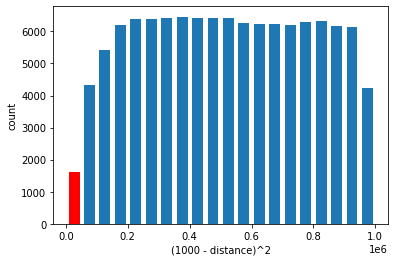

Bin:  (101.2169, 201.16731)
Minimum bin is  (950011.1481954296, 999964.498270512)  with value  4471
To achieve 10^4 events, we need a test set with  2643817.9378215163  muon events
Test set must be  2.2366360993066428  as large


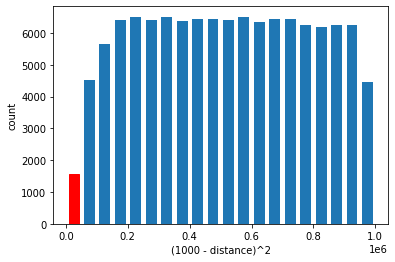

Bin:  (201.16731, 301.1177)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4449
To achieve 10^4 events, we need a test set with  2656891.436277815  muon events
Test set must be  2.2476961114857272  as large


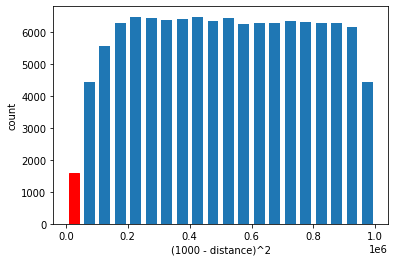

Bin:  (301.1177, 401.0681)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4428
To achieve 10^4 events, we need a test set with  2669491.8699186994  muon events
Test set must be  2.2583559168925023  as large


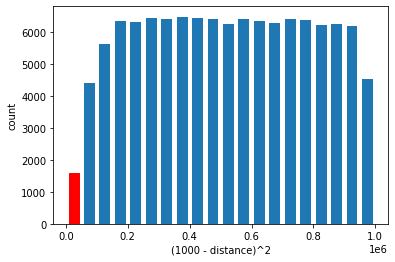

Bin:  (401.0681, 501.01852)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4510
To achieve 10^4 events, we need a test set with  2620955.6541019958  muon events
Test set must be  2.2172949002217295  as large


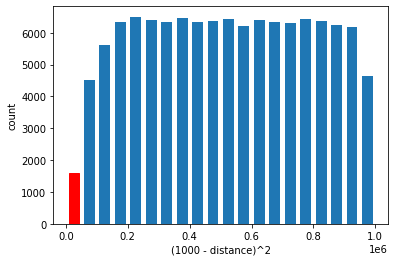

Bin:  (501.01852, 600.96893)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4305
To achieve 10^4 events, we need a test set with  2745763.0662020906  muon events
Test set must be  2.3228803716608595  as large


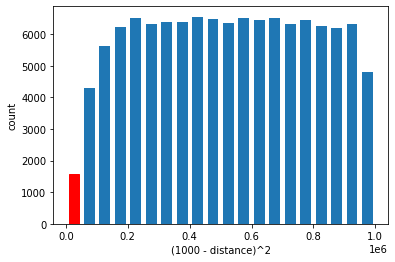

Bin:  (600.96893, 700.9194)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4503
To achieve 10^4 events, we need a test set with  2625029.9800133244  muon events
Test set must be  2.2207417277370642  as large


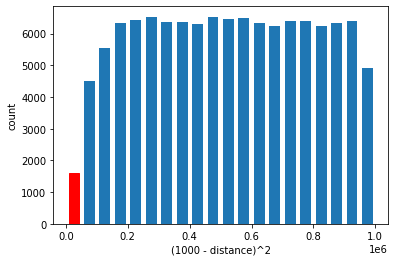

Bin:  (700.9194, 800.86975)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4382
To achieve 10^4 events, we need a test set with  2697514.833409402  muon events
Test set must be  2.2820629849383844  as large


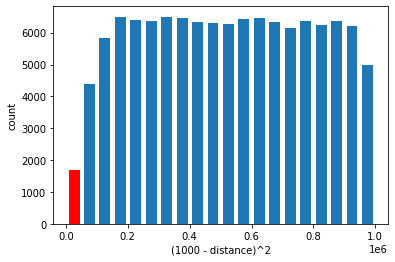

Bin:  (800.86975, 900.8202)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4396
To achieve 10^4 events, we need a test set with  2688924.0218380345  muon events
Test set must be  2.2747952684258417  as large


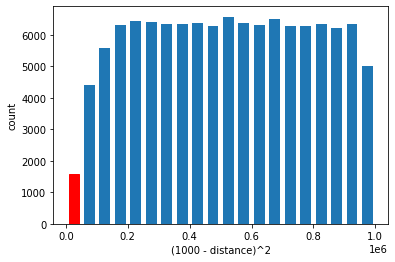

Bin:  (900.8202, 1000.77057)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4395
To achieve 10^4 events, we need a test set with  2689535.8361774744  muon events
Test set must be  2.2753128555176336  as large


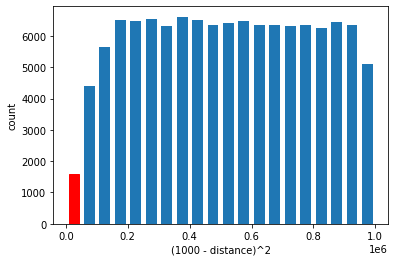

In [71]:
test_e_idxs       = np.where(dataset_info[2]['labels'] == 1)[0]
test_e_energies   = dataset_info[2]['energies'][test_e_idxs]
test_dist_to_wall = dataset_info[2]['d_to_wall']

# bin energy data
energy_hist, energy_bins = np.histogram(test_e_energies, bins=10)
print("Energy bins: ", energy_bins)

size_of_data_subset = len(test_e_idxs)
max_val = size_of_data_subset
for i in range(len(energy_bins) - 1):
    print("Bin: ", (energy_bins[i], energy_bins[i + 1]))
    test_set_size = analyze_bin_data(test_e_energies, test_e_idxs, energy_bins[i], energy_bins[i + 1], plot=True)
    if test_set_size > max_val:
        max_val = test_set_size

In [72]:
print("Overall, to achieve 10^4 events, we need a test set with ", max_val, " electron events")
print("Overall, test set must be ",  max_val / size_of_data_subset, " as large")

Overall, to achieve 10^4 events, we need a test set with  2788513.8004246284  electron events
Overall, test set must be  2.359046945034206  as large


# Event Breakdown By Energy for Photons

Energy bins:  [   1.8741896  101.841675   201.80917    301.77664    401.74414
  501.71164    601.67914    701.6466     801.6141     901.5816
 1001.5491   ]
Bin:  (1.8741896, 101.841675)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4329
To achieve 10^4 events, we need a test set with  2739018.249018249  muon events
Test set must be  2.31000231000231  as large


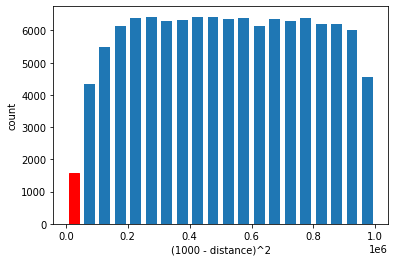

Bin:  (101.841675, 201.80917)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4476
To achieve 10^4 events, we need a test set with  2649063.8963360144  muon events
Test set must be  2.234137622877569  as large


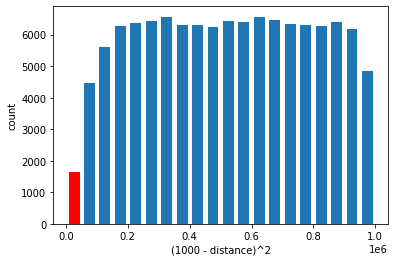

Bin:  (201.80917, 301.77664)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4399
To achieve 10^4 events, we need a test set with  2695433.0529665835  muon events
Test set must be  2.2732439190725167  as large


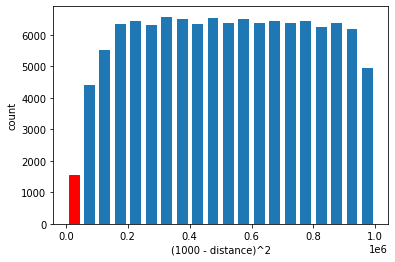

Bin:  (301.77664, 401.74414)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4404
To achieve 10^4 events, we need a test set with  2692372.842870118  muon events
Test set must be  2.270663033605813  as large


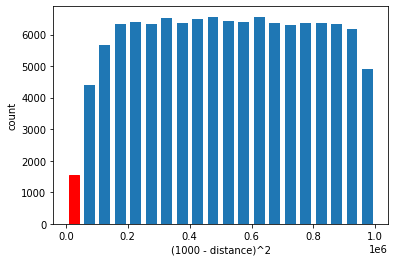

Bin:  (401.74414, 501.71164)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4407
To achieve 10^4 events, we need a test set with  2690540.049920581  muon events
Test set must be  2.269117313365101  as large


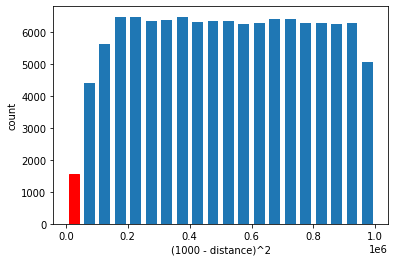

Bin:  (501.71164, 601.67914)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4498
To achieve 10^4 events, we need a test set with  2636107.1587372166  muon events
Test set must be  2.223210315695865  as large


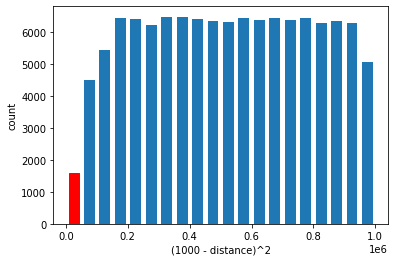

Bin:  (601.67914, 701.6466)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4529
To achieve 10^4 events, we need a test set with  2618063.5901965112  muon events
Test set must be  2.20799293442261  as large


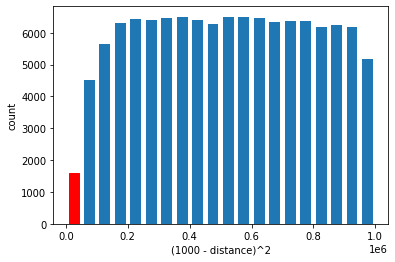

Bin:  (701.6466, 801.6141)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4433
To achieve 10^4 events, we need a test set with  2674759.7563726595  muon events
Test set must be  2.2558087074216107  as large


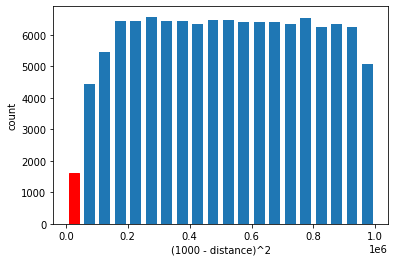

Bin:  (801.6141, 901.5816)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4386
To achieve 10^4 events, we need a test set with  2703422.252621979  muon events
Test set must be  2.279981760145919  as large


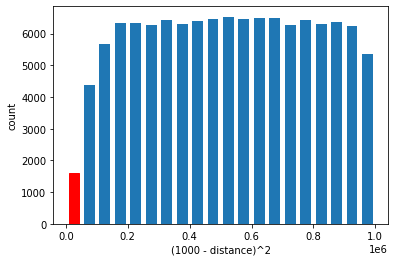

Bin:  (901.5816, 1001.5491)
Minimum bin is  (50850.846843946354, 100804.19691902876)  with value  4321
To achieve 10^4 events, we need a test set with  2744089.3311733394  muon events
Test set must be  2.314279102059708  as large


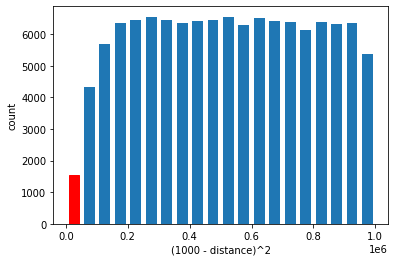

In [73]:
test_gamma_idxs       = np.where(dataset_info[2]['labels'] == 0)[0]
test_gamma_energies   = dataset_info[2]['energies'][test_gamma_idxs]
test_dist_to_wall = dataset_info[2]['d_to_wall']

# bin energy data
energy_hist, energy_bins = np.histogram(test_gamma_energies, bins=10)
print("Energy bins: ", energy_bins)

size_of_data_subset = len(test_gamma_idxs)
max_val = size_of_data_subset
for i in range(len(energy_bins) - 1):
    print("Bin: ", (energy_bins[i], energy_bins[i + 1]))
    test_set_size = analyze_bin_data(test_gamma_energies, test_gamma_idxs, energy_bins[i], energy_bins[i + 1], plot=True)
    if test_set_size > max_val:
        max_val = test_set_size

In [74]:
print("Overall, to achieve 10^4 events, we need a test set with ", max_val, " gamma events")
print("Overall, test set must be ",  max_val / size_of_data_subset, " as large")

Overall, to achieve 10^4 events, we need a test set with  2744089.3311733394  gamma events
Overall, test set must be  2.314279102059708  as large
